In [2]:
if 'sc' not in locals():
    from pyspark.context import SparkContext
    from pyspark.sql.context import SQLContext
    from pyspark.sql.session import SparkSession
    
    sc = SparkContext()
    sqlContext = SQLContext(sc)
    spark = SparkSession(sc)

def run_sql(statement):
    try:
        result = sqlContext.sql(statement)
    except Exception as e:
        print(e.desc, '\n', e.stackTrace)
        return
    return result


tbls = run_sql('show tables')
tbls.toPandas()

,database,tableName,isTemporary


In [46]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType

# File location and type
file_covid = "COVID19_line_list_data.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# define the schema based on the dataset dictionary
# this is available here: https://archive.ics.uci.edu/ml/datasets/adult
schema = StructType([
      StructField('case_in_country', DoubleType()),
      StructField('reporting date', StringType()),
      StructField('country', DoubleType()),
      StructField('gender', StringType()),
      StructField('age', DoubleType()),
      StructField('death', DoubleType()),
      StructField('recovered', DoubleType()),
])

# The applied options are for CSV files. For other file types, these will be ignored.
covid_df = (spark.read.format(file_type) 
                    #.schema(schema)
                    .option("inferSchema", infer_schema) 
                    .option("header", first_row_is_header) 
                    .option("sep", delimiter) 
                    .load(file_covid))

In [117]:
print('Covid Dataset Schema')
covid_df.printSchema()

Covid Dataset Schema
root
 |-- id: integer (nullable = true)
 |-- case_in_country: integer (nullable = true)
 |-- reporting date: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- symptom_onset: string (nullable = true)
 |-- If_onset_approximated: string (nullable = true)
 |-- hosp_visit_date: string (nullable = true)
 |-- exposure_start: string (nullable = true)
 |-- exposure_end: string (nullable = true)
 |-- visiting Wuhan: string (nullable = true)
 |-- from Wuhan: string (nullable = true)
 |-- death: string (nullable = true)
 |-- recovered: string (nullable = true)
 |-- symptom: string (nullable = true)
 |-- source: string (nullable = true)
 |-- link: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = tru

In [65]:
covid_df.registerTempTable("covid")
tbls = run_sql('show tables')
tbls.toPandas()

,database,tableName,isTemporary
0,,covid,True


In [150]:
df = run_sql("SELECT * FROM covid LIMIT 5")
df.toPandas()

,id,case_in_country,reporting date,_c3,summary,location,country,gender,age,symptom_onset,...,recovered,symptom,source,link,_c21,_c22,_c23,_c24,_c25,_c26
0,1,NaN,1/20/2020,None,First confirmed imported COVID-19 pneumonia pa...,"Shenzhen, Guangdong",China,male,66,01/03/20,...,0,None,Shenzhen Municipal Health Commission,http://wjw.sz.gov.cn/wzx/202001/t20200120_1898...,None,None,None,None,None,None
1,2,NaN,1/20/2020,None,First confirmed imported COVID-19 pneumonia pa...,Shanghai,China,female,56,1/15/2020,...,0,None,Official Weibo of Shanghai Municipal Health Co...,https://www.weibo.com/2372649470/IqogQhgfa?fro...,None,None,None,None,None,None
2,3,NaN,1/21/2020,None,First confirmed imported cases in Zhejiang: pa...,Zhejiang,China,male,46,01/04/20,...,0,None,Health Commission of Zhejiang Province,http://www.zjwjw.gov.cn/art/2020/1/21/art_1202...,None,None,None,None,None,None
3,4,NaN,1/21/2020,None,new confirmed imported COVID-19 pneumonia in T...,Tianjin,China,female,60,NA,...,0,None,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,None,None,None,None,None,None
4,5,NaN,1/21/2020,None,new confirmed imported COVID-19 pneumonia in T...,Tianjin,China,male,58,NA,...,0,None,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,None,None,None,None,None,None


In [68]:
df.dtypes

[('id', 'int'),
 ('case_in_country', 'int'),
 ('reporting date', 'string'),
 ('_c3', 'string'),
 ('summary', 'string'),
 ('location', 'string'),
 ('country', 'string'),
 ('gender', 'string'),
 ('age', 'string'),
 ('symptom_onset', 'string'),
 ('If_onset_approximated', 'string'),
 ('hosp_visit_date', 'string'),
 ('exposure_start', 'string'),
 ('exposure_end', 'string'),
 ('visiting Wuhan', 'string'),
 ('from Wuhan', 'string'),
 ('death', 'string'),
 ('recovered', 'string'),
 ('symptom', 'string'),
 ('source', 'string'),
 ('link', 'string'),
 ('_c21', 'string'),
 ('_c22', 'string'),
 ('_c23', 'string'),
 ('_c24', 'string'),
 ('_c25', 'string'),
 ('_c26', 'string')]

In [70]:
columns_to_drop = ['link', 'source', '_c21', '_c22', '_c23', '_c24', '_c25', '_c26,','_c3', 'exposure_start', 'visiting Wuhan', 'from Wuhan', 'location']
df = df.drop(*columns_to_drop)

DataFrame[]

In [192]:
result = run_sql("SELECT gender,  SUM (death) AS death_amount, COUNT (id) AS people, ROUND(AVG(age) ,2) AS average_age, ROUND(AVG(death) ,2) AS average_death FROM covid GROUP BY gender ORDER BY average_death DESC limit 3")
result.toPandas()

,gender,death_amount,people,average_age,average_death
0,male,30.0,518,49.78,0.06
1,female,12.0,382,49.63,0.03
2,USA,0.0,1,NaN,0.00


In [193]:
sqlContext.registerDataFrameAsTable(result, "result")
tbls = run_sql('show tables')
tbls.toPandas()

,database,tableName,isTemporary
0,,covid,True
1,,result,True


In [194]:
run_sql("SELECT * FROM result").limit(5).toPandas()

,gender,death_amount,people,average_age,average_death
0,male,30.0,518,49.78,0.06
1,female,12.0,382,49.63,0.03
2,USA,0.0,1,NaN,0.00


In [195]:
import pandas as pd

# do some analysis
result = run_sql("SELECT gender,  SUM (death) AS death_amount, COUNT (id) AS people, ROUND(AVG(age) ,2) AS average_age, ROUND(AVG(death) ,2) AS average_death FROM covid GROUP BY gender ORDER BY average_death DESC limit 3")
result.toPandas()

# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

df_pandas.head()

,gender,death_amount,people,average_age,average_death
0,male,30.0,518,49.78,0.06
1,female,12.0,382,49.63,0.03
2,Paris,0.0,1,NaN,0.00


In [196]:
df_pandas.describe()

,death_amount,people,average_age,average_death
count,3.000000,3.000000,2.000000,3.000
mean,14.000000,300.333333,49.705000,0.030
std,15.099669,268.000622,0.106066,0.030
min,0.000000,1.000000,49.630000,0.000
25%,6.000000,191.500000,49.667500,0.015
50%,12.000000,382.000000,49.705000,0.030
75%,21.000000,450.000000,49.742500,0.045
max,30.000000,518.000000,49.780000,0.060


In [197]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         3 non-null      object 
 1   death_amount   3 non-null      float64
 2   people         3 non-null      int64  
 3   average_age    2 non-null      float64
 4   average_death  3 non-null      float64
dtypes: float64(3), int64(1), object(1)
memory usage: 248.0+ bytes


<AxesSubplot:ylabel='gender'>

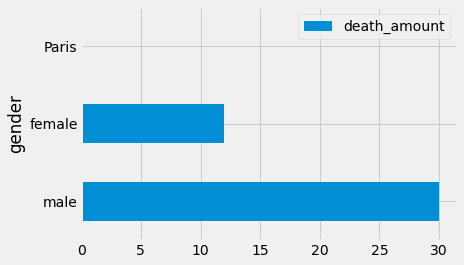

In [201]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

# get simple plot on the pandas data
df_pandas.plot(kind='barh', x='gender', y='death_amount')